# Exercise 1 - Pandas and PyTerrier introduction

In this notebook, we recap [Pandas](https://pandas.pydata.org/), as well as provide an introduction to [PyTerrier](https://github.com/terrier-org/pyterrier).  This exercise is **an individual assessment** (with a weighting of 5%). 

At the end of this lab, you must complete the corresponding Exercise 1 assessment Quiz instance on the Moodle page, as well as download the ipynb file and submit it along your answers to the Quiz by **Thursday 10th June 4:40pm**.

The intended learning outcomes of this lab are:
1. provide an overview/refresher of Pandas for relational data manipulation, including:
  - creating Pandas dataframes
  - applying relational algebra operations on dataframes (projection, restriction, set-union)
  - joining dataframes
  - applying functions on dataframes
2. provide an introduction to PyTerrier
  - installation
  - indexing a collection
  - accessing an index
  - the BatchRetrieve transformer for searching an index 
  - reformulating queries
  - composing transformers together to make retrieval pipelines

Pre-requisites:
 - We assume that you are confident in programming Python, including [lambda functions](https://realpython.com/python-lambda/).
 - We will **only be supporting notebooks on the Google Colab platform**.
 - You can also try to use your own personal machine, but if you have problems, you should resort to using Colab.

Related Reading:
 - [Pandas documentation](https://pandas.pydata.org/docs/)
 - [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/)


## Part 1 - Pandas

In [ ]:
# we need to import pandas. We commonly rename it to pd, to make commands shorter
import pandas as pd

# let's not truncate Pandas output too much
pd.set_option('display.max_colwidth', 150)

### Constructing a Pandas dataframe

In [ ]:
# let's take our data from a list, where each element is the rows of the data.
population_data = [
  ['California', 38332521],
  ['Texas', 26448193],                  
  ['Illinois', 12882135]                  
]

# now we construct a dataframe object. this is our relation
# we need to name the columns
population_df = pd.DataFrame(population_data, columns=['State', 'Population']) 
# if we put a variable last in the code cell, its content will be printed
population_df

,State,Population
0,California,38332521
1,Texas,26448193
2,Illinois,12882135


As you can see, this is very much like a relation, with a name (`population_df`), a header with attribute names, and rows.

We can also make a dataframe using a dictionary:

In [ ]:
population_df = pd.DataFrame({
      'State' : ['California', 'Texas', 'Illinois'],
      'Population' : [38332521, 26448193, 12882135]
    })
population_df

,State,Population
0,California,38332521
1,Texas,26448193
2,Illinois,12882135


Dataframes have attributes (such as length).


In [ ]:
len(population_df)

3

Each column is typed (actually using Numpy datatypes)

In [ ]:
population_df.dtypes

State         object
Population     int64
dtype: object


### Projection

Ok, we now have a dataframe. Unlike a relation, this has order, so we can ask to *select* the first or second rows:

In [ ]:
population_df.iloc[1]

State            Texas
Population    26448193
Name: 1, dtype: object

We'll return to selection shortly.

We can *project* one column:

In [ ]:
population_df['Population']

0    38332521
1    26448193
2    12882135
Name: Population, dtype: int64

When both projecting single rows or columns, we get an object of type [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/reference/series.html). 

In [ ]:
type(population_df['Population'])

pandas.core.series.Series

A Pandas Series can be thought of as a kind of dictionary/key-value store. We can ask for a given value using 'dot notation', or square brackets:

In [ ]:
population_df.iloc[1].State

'Texas'

In [ ]:
population_df.iloc[1]["State"]

'Texas'

On the other hand, if we wanted to project many columns we would end up with a *dataframe* that looks similar to the original one, just with columns reordered).

Note how we use an additional `[]` when we want to project many columns - i.e. we are projecting a *list* of columns.

In [ ]:
population_df[['Population', 'State']]

,Population,State
0,38332521,California
1,26448193,Texas
2,12882135,Illinois


### Union


One of the simplest operations in relational algebra is data union. That is uniting two tables to create a third, which contains all the rows of both the first and the second table!

Here, we're interested in the union of DataFrames. With Pandas, this operation is carried out using `pd.concat`.

In [ ]:
#we've just been informed about the population of some east coast states
population_df_eastcoast = pd.DataFrame([['New York', 19651127], ['Florida', 19552860]], columns=['State', 'Population'])

#we can make a new dataframe by concatenating the dataframes - this is the union. 
population_all_df = pd.concat([population_df, population_df_eastcoast])
population_all_df

,State,Population
0,California,38332521
1,Texas,26448193
2,Illinois,12882135
0,New York,19651127
1,Florida,19552860


###Selection

Selection is the filtering of rows. We can do this based on conditions, for instance with a population greater than a threshold, e.g. 30M.

In [ ]:
population_all_df[population_all_df['Population'] > 3e7]

,State,Population
0,California,38332521


What happened here? Let's break this down.

Inside the brackets is 
```python
population_all_df['Population'] > 3e7
```
This identifies all rows that have a population greater than 30 million (I'm using 3e7, a shorthand scientific notation for 30 million). Let's run that by itself

In [ ]:
population_all_df['Population'] > 3e7

0     True
1    False
2    False
0    False
1    False
Name: Population, dtype: bool

It evaluates the expression Population > 3e7 for each row, and returns a kind of list (actually a Pandas [Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)), with `True` and `False` values for each row, determining if the row meets the selection condition.

By inserting this into `population_all_df[]`, we determine which rows to return (i.e. only those for California).

###Join

Another very useful function to manipulate Dataframes is `pd.merge`, which allows you to **join** DataFrames.

A join assembles information from one table A with that from another table B according to a chosen criterion. This criterion is called the join condition. This condition is composed of one or more columns that are common to A and B.

Here is a quick example to help explain. Let's imagine that we have two Dataframes:

*  `df1`  containing a list of employees and the names of the departments in which they work,

*  `df2`  containing the same list of employees and their dates of entry into the company.

The `pd.merge` function allows us to transform these two Dataframes into one, containing both information.

![alt text](https://user.oc-static.com/upload/2018/11/19/15426263274571_15190382351255_foo.png)

In [ ]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'department': ['Accounting', 'Engineering', 'Engineering', 'HR']})
                    
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'date': [2004, 2008, 2012, 2014]})
df3 = pd.merge(df1, df2)
df3

,employee,department,date
0,Bob,Accounting,2008
1,Jake,Engineering,2012
2,Lisa,Engineering,2004
3,Sue,HR,2014


`pd.merge` automatically recognised that the `employee` column was common to both Dataframes, and used it as a join condition. This is akin to a **natural join** in relational algebra. We might explicitly make this clear using the `on=` kwarg.

```python
df3 = pd.merge(df1, df2, on="employee")
```

But if these 2 columns had different names (for example employee on df1 and emp_name on df2), then you would instead write:

```python
  df3 = pd.merge(df1, df2, left_on="employee", right_on="emp_name")
```

(This would have been an equi-join).

We can do left and right outer joins using the `how=` kwarg, which control what we do with rows from the left or right dataframes that don't have a match in the other. See the [Pandas merge documentation for more details](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html).


Gotcha: There is also a `pd.join()` method, which does NOT do the same thing (it only operates on special columns called indexes, which we dont use here). Only use `pd.merge()`.


### Apply

Sometimes we want to apply a function on a row of a dataframe. [Pandas apply() function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) is very useful for this.

For instance, perhaps we want to add a string representation of the states population, e.g. `"38M"` for the population of California.

I'm going to use a nice Python function from [StackExchange](https://stackoverflow.com/a/3155023):


In [ ]:
import math
millnames = ['','K','M','B','T']
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
  
millify(38332521)

'38M'

Ok, so how to "apply" this function to our dataframe. 

Well, let's take the Series for the population columns, and apply the function. That returns a new Series with the new string form of the column. 

In [ ]:
population_all_df["Population"].apply(millify)

0    38M
1    26M
2    13M
0    20M
1    20M
Name: Population, dtype: object

In this case, for *each* Population value, millify is called on the numeric value. 

We can also apply on an entire dataframe. Here, we use a lambda function to call millify on the attribute we care about. The lambda is called for each row of population_all_df, being passed that row as a Pandas series. We use the square brackets notation to get the Population value. Finally, `axis=1` tells Pandas we are operating row-by-row, not column-by-column, which is the default. 

In [ ]:
population_all_df.apply(lambda row: millify(row["Population"]), axis=1)

0    38M
1    26M
2    13M
0    20M
1    20M
dtype: object

Ok, so how can we make a new column. Well we can assign columns to dataframes too.

In [ ]:
population_all_df["Pop Human"] = population_all_df["Population"].apply(millify)
population_all_df

,State,Population,Pop Human
0,California,38332521,38M
1,Texas,26448193,26M
2,Illinois,12882135,13M
0,New York,19651127,20M
1,Florida,19552860,20M


Beautiful!

### Pandas Exercises


####Q1. Creating a Pandas dataframe

Create a dataframe `area_df` for the following information about states:

State| Area
--- | ---
California | 423967
Texas | 695662
New York | 141297
Florida | 170312
Illinois | 149995



In [ ]:
#YOUR SOLUTION
data_f = pd.DataFrame({'State': ['California', 'Texas', 'New York', 'Florida','Illinois'],
                    'Area': [423967, 695662, 141297, 170312,149995]})
data_f


,State,Area
0,California,423967
1,Texas,695662
2,New York,141297
3,Florida,170312
4,Illinois,149995


#### Q2. What are the names of states which have an area less than 150,000?



In [ ]:
#YOUR SOLUTION
data_f[data_f['Area'] < 150000]

,State,Area
2,New York,141297
4,Illinois,149995


#### Q3. Provide the population and area for the states of Texas and Florida in a single dataframe

It should have columns State, Population, Area, and have 2 rows.

In [ ]:
#YOUR SOLUTION
data_f2 = pd.merge(data_f, population_all_df)
data_f2 = data_f2[['State','Population','Area']]
data_f3 = data_f2[(data_f2['State'].__eq__('Texas')) | (data_f2['State'].__eq__('Florida'))]
data_f3

,State,Population,Area
1,Texas,26448193,695662
3,Florida,19552860,170312


## Part 2 - PyTerrier

PyTerrier is a Python framework, but uses the underlying [Terrier.org information retrieval toolkit](http://terrier.org) for many indexing and retrieval operations. While PyTerrier was new in 2020, Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform IR experiments in Python, but using the mature Terrier platform for the expensive indexing and retrieval operations. 

In the following, we introduce everything you need to know about PyTerrier, and also provide appropriate links to relevant parts of the [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/).


### Installation & Configuration

PyTerrier is installed as follows. This might take a few minutes, so you can read on.

In [ ]:
!pip install python-terrier

The next step is to initialise PyTerrier. This is performed using PyTerrier's `init()` method. The `init()` method is needed as PyTerrier must download Terrier's jar file and start the Java virtual machine. We prevent init() from being called more than once by checking `started()`.

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

### Documents, Indexing and Indexes

Much of PyTerrier's view of the world is wrapped up in Pandas dataframes. Let's consider some textual documents in a dataframe.


In [ ]:
import pandas as pd
docs_df = pd.DataFrame([
    ["d1", "this is the first document of many documents"],
    ["d2", "this is another document"],
    ["d3", "the topic of this document is unknown"]
], columns=["docno", "text"])


In [ ]:
docs_df

,docno,text
0,d1,this is the first document of many documents
1,d2,this is another document
2,d3,the topic of this document is unknown


Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents. The index is written into a directory called `index_3docs`. 

In [ ]:
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
indexref = indexer.index(docs_df["text"], docs_df["docno"])
indexref.toString()

'./index_3docs/data.properties'

An IndexRef is essentially a string saying where an index is stored. 

Indeed, we can look in the `index_3docs` directory and see that it has created various small files. The filenames give hints to the corresponding data structures: 
 - some files relating to a lexicon (aka vocabulary)
 - a file relating to the inverted index
 - a file relating to the direct index (aka forward index, used for QE)
 - files relating to document metadata (e.g. storing the unique identifiers for documents) and document lengths


In [ ]:
!ls -lh index_3docs/

total 36K
-rw-r--r-- 1 root root    3 Jun 11 03:40 data.direct.bf
-rw-r--r-- 1 root root   51 Jun 11 03:40 data.document.fsarrayfile
-rw-r--r-- 1 root root    4 Jun 11 03:40 data.inverted.bf
-rw-r--r-- 1 root root  344 Jun 11 03:40 data.lexicon.fsomapfile
-rw-r--r-- 1 root root  249 Jun 11 03:40 data.lexicon.fsomaphash
-rw-r--r-- 1 root root   24 Jun 11 03:40 data.meta.idx
-rw-r--r-- 1 root root   48 Jun 11 03:40 data.meta.zdata
-rw-r--r-- 1 root root 4.1K Jun 11 03:40 data.properties


How can we make an IndexRef useful - we can load it to an actual index - pt.IndexFactory.of() is the relevant factory. 

In [ ]:
index = pt.IndexFactory.of(indexref)

#lets see what Python type index is.
type(index)

jnius.reflect.org.terrier.structures.Index

Ok, so this object refers to Terrier's [Index type](http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html). Check the linked Javadoc - you will see that this Java object has methods such as:
 - getCollectionStatistics()
 - getInvertedIndex()
 - getLexicon() 

Let's see what's in the CollectionStatistics:

In [ ]:
print(index.getCollectionStatistics())

Number of documents: 3
Number of terms: 4
Number of postings: 6
Number of fields: 0
Number of tokens: 7
Field names: []
Positions:   false



Ok, that seems fair - we have 3 documents. But why only 4 terms? 
Let's check the [Lexicon](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html), which is our vocabulary. Fortunately, the Lexicon can be iterated easily from Python:

In [ ]:
for kv in index.getLexicon():
  print("%s (%s) -> %s (%s)" % (kv.getKey(), type(kv.getKey()), kv.getValue(), type(kv.getValue()) ) )

document (<class 'str'>) -> term0 Nt=3 TF=4 maxTF=2 @{0 0 0} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
first (<class 'str'>) -> term1 Nt=1 TF=1 maxTF=1 @{0 0 7} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
topic (<class 'str'>) -> term2 Nt=1 TF=1 maxTF=1 @{0 1 1} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)
unknown (<class 'str'>) -> term3 Nt=1 TF=1 maxTF=1 @{0 1 5} (<class 'jnius.reflect.org.terrier.structures.LexiconEntry'>)


Here, iterating over the Lexicon returns a pair of String term, and a [LexiconEntry](http://terrier.org/docs/current/javadoc/org/terrier/structures/LexiconEntry.html) -- which itself is an [EntryStatistics](http://terrier.org/docs/current/javadoc/org/terrier/structures/EntryStatistics.html) -- and contains information including the statistics of that term.


So what did we find? Here are some observations:
 - we only have 4 unique terms, as stopwords were removed
 - we have one term for `"document"`, even though `"documents"` occurred in document "d1". 
 
Both these observations make sense, as indeed Terrier removes standard stopwords and applies Porter's stemmer by default.

Further:
 - `Nt` is the number of unique documents that each term occurs in. This is useful for calculating IDF
 - `TF` is the total number of occurrences - some weighting models use this instead of Nt.
 - The numbers in the `@{}` are a pointer - they tell Terrier where the postings are for that term in the inverted index data structure.

Finally, we can also use the square bracket notation to lookup terms in Terrier's lexicon. This is equivalent to [Lexicon.getLexiconEntry("chemical")](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html#getLexiconEntry(KEY))


In [ ]:
index.getLexicon()["document"].toString()

'term0 Nt=3 TF=4 maxTF=2 @{0 0 0}'

Let's now think about the inverted index. Remember from Lecture 2 that the inverted index tells us in which *documents* each term occurs in. The LexiconEntry is the pointer that tell us where to find the postings for that term in the inverted index.

In [ ]:
pointer = index.getLexicon()["document"]
for posting in index.getInvertedIndex().getPostings(pointer):
  print(posting.toString() + " doclen=%d" % posting.getDocumentLength())

ID(0) TF(2) doclen=3
ID(1) TF(1) doclen=1
ID(2) TF(1) doclen=3


Ok, so we can see that `"document"` occurs once in each of the three documents. NB: Terrier counts documents as integers from 0 (called *docids*). It records the mapping back to *docnos* (the string form, i.e. "d1", "d2") in a separate data structure called the metaindex.

Similarly, we can see what terms occur in document d1, by using a datastructure called the *direct* index. You can think of this as the opposite of the inverted index: the inverted index tell us, for each term, which documents contain that term; the direct index tells us, for each document, which terms it contains.

Let's define a function to show us the contents of a document using the direct index. This a translation of [the Java code for displaying the contents of a document in the Terrier documentation](https://github.com/terrier-org/terrier-core/blob/5.x/doc/extend_retrieval.md#what-terms-occur-in-the-11th-document). When using our function, we can specify which document either by docno (string) or docid (int).

In [ ]:
def get_document_direct(index, docno=None, docid=None):
  if docid is None and docno is None:
    raise ValueError("Must specify docno or docid")
  if docno is not None:
    docid = index.getMetaIndex().getDocument("docno", docno)
  else:
    docno = index.getMetaIndex().getItem("docno", docid)
  rtr = "Docno %s (docid %d)\n" % (docno, docid)
  pointer = index.getDocumentIndex().getDocumentEntry(docid)
  for p in index.getDirectIndex().getPostings(pointer):
    termid = p.getId()
    term = index.getLexicon()[termid].getKey()
    rtr += ("\t%s %d\n" % ( term, p.getFrequency()))
  return rtr

In [ ]:
print(get_document_direct(index, docno="d1"))

Docno d1 (docid 0)
	document 2
	first 1



In [ ]:
print(get_document_direct(index, docid=0))

Docno d1 (docid 0)
	document 2
	first 1



### Searching an Index

Our way into search in PyTerrier is called BatchRetrieve. BatchRetrieve is configured by specifying an index and a weighting model. We then search for a single-word query, `"document"`.

In [ ]:
br = pt.BatchRetrieve(index, wmodel="Tf")
br.search("document")

,qid,docid,docno,rank,score,query
0,1,0,d1,0,2.0,document
1,1,2,d3,1,1.0,document
2,1,1,d2,2,1.0,document


So `search()` returns a dataframe with columns:
 - qid: this is by default "1", since it's our first and only query
 - docid: Terrier' internal integer for each doucment
 - docno: the external (string) unique identifier for each document
 - score: the total frequency of the query (terms) in each document
 - rank: A handy attribute showing the descending order by score
 - query: the input query

As expected, the Tf weighting model used here only counts the frequencies of the query terms in each document, i.e.:
$$
score(d,Q) = \sum_{t \in Q} tf_{t,d}
$$

Hence, it's clear that document d1 should be the highest scored document with two occurrences (c.f. `'document'` and `'documents'`).  

We can also pass a dataframe of one or more queries to the `transform()` method (rather than the `search()` method) of a transformer, with queries numbered "q1", "q2" etc.. 

In [ ]:
import pandas as pd
queries = pd.DataFrame([["q1", "document"], ["q2", "first document"]], columns=["qid", "query"])
br.transform(queries)

,qid,docid,docno,rank,score,query
0,q1,0,d1,0,2.0,document
1,q1,2,d3,1,1.0,document
2,q1,1,d2,2,1.0,document
3,q2,0,d1,0,3.0,first document
4,q2,2,d3,1,1.0,first document
5,q2,1,d2,2,1.0,first document


In fact, we are usually calling `transform()`, so it's the default method - i.e. 
`br.transform(queries)` can be more succinctly written as `br(queries)`.

In [ ]:
br(queries)

,qid,docid,docno,rank,score,query
0,q1,0,d1,0,2.0,document
1,q1,2,d3,1,1.0,document
2,q1,1,d2,2,1.0,document
3,q2,0,d1,0,3.0,first document
4,q2,2,d3,1,1.0,first document
5,q2,1,d2,2,1.0,first document


### Moving on up

OK, having 3 documents is quite trivial, so let's move upto a slightly larger corpus of documents. We'll be using Vaswani NPL. Terrier has a handy `get_dataset()` API, which allows us to download a ready-made index. 

In [ ]:
vaswani_dataset = pt.get_dataset("vaswani")
index = pt.IndexFactory.of(vaswani_dataset.get_index())


#### **Task 1**
- What are the statistics of our index?
- Can you get a feeling for what kind of documents this index contains by inspecting a few documents. e.g. look into the content of the index of docids 0, 10 and 100

In [ ]:
#YOUR SOLUTION
print("---- The statistics of Index----")
print(index.getCollectionStatistics())
print("--------------------------------")

print("---- Document 0 ----")
print(get_document_direct(index, docid=0))
print("--------------------------------")

print("---- Document 10 ----")
print(get_document_direct(index, docid=10))
print("--------------------------------")

print("---- Document 100 ----")
print(get_document_direct(index, docid=100))
print("--------------------------------")

---- The statistics of Index----
Number of documents: 11429
Number of terms: 7756
Number of postings: 224573
Number of fields: 0
Number of tokens: 271581
Field names: []
Positions:   false

--------------------------------
---- Document 0 ----
Docno 1 (docid 0)
	storag 1
	random 1
	flexibl 1
	data 1
	system 1
	compact 1
	sequenti 1
	digit 1
	memori 1
	bit 1
	access 1
	capac 2

--------------------------------
---- Document 10 ----
Docno 11 (docid 10)
	circuit 3
	transistor 1
	us 1
	obtain 1
	switch 2
	design 1
	affect 1
	plot 1
	junction 1
	characterist 1
	paramet 1
	relat 1
	theoret 1
	load 1
	bistabl 1
	curv 1
	mai 1
	diagram 1
	line 1
	static 1

--------------------------------
---- Document 100 ----
Docno 101 (docid 100)
	measur 1
	obtain 1
	discuss 1
	mai 1
	third 1
	analysi 1
	result 1
	taken 1
	function 1
	molecular 1
	observ 1
	rel 1
	ion 1
	show 1
	spectromet 1
	satellit 1
	artifici 1
	intens 1
	km 2
	atmospher 1
	height 2
	variat 1
	earth 1
	graph 1
	latitud 2
	interv 1
	spec

So Vaswani is a reasonable index - let's examine the extent that it exhibits some of the textual properties we would expect.

#### **Task 2**

Use a matplotlib histogram to examine the distribution of the terms occurring in the Lexicon - i.e. it should be possible to read for a given frequency range, the number of terms that have that frequency.

Hint: What method of the LexiconEntry can be used to determine the frequency for each term?

Hint: it might be easier to read if you apply a logarithmic scale for the y-axis. Allow matplotlib to use its default number of bins (which is 10).

<p>&nbsp;</p>

#### **Stretch Task (Optional)**

Next, let's try to see if Vaswani follows a Zipfian distribution. In terms of probabilities, we have 
$$
r.Pr_t \approx A
$$
where $r$ is the rank of the term, and $Pr_t$ is the probability of the term. To check how well Vaswani follows Zipf, reproduce slide 14 from Lecture 3 (concerning AP89) for this collection. We expect that Zipf's law will not hold for low and high ranked terms.

Hint: SciPy's [rankdata()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rankdata.html) function might be useful for getting the rank of any term frequency.

Hint: To obtain $Pr_t$, you should compare each term's frequency to one of the collection statistics. 


(array([7.54e+03, 1.39e+02, 3.90e+01, 2.00e+01, 5.00e+00, 8.00e+00,
        0.00e+00, 3.00e+00, 1.00e+00, 1.00e+00]),
 array([1.0000e+00, 3.0630e+02, 6.1160e+02, 9.1690e+02, 1.2222e+03,
        1.5275e+03, 1.8328e+03, 2.1381e+03, 2.4434e+03, 2.7487e+03,
        3.0540e+03]),
 <a list of 10 Patch objects>)

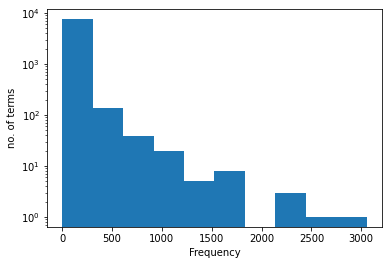

In [ ]:
#YOUR SOLUTION
import matplotlib.pyplot as plt

freq = []
keys = []

for entry in index.getLexicon():
  keys.append(entry.getKey())

for entry in keys:
  freq.append(index.getLexicon()[entry].getFrequency())
plt.xlabel("Frequency")
plt.ylabel("no. of terms")
plt.hist(freq, log = True)

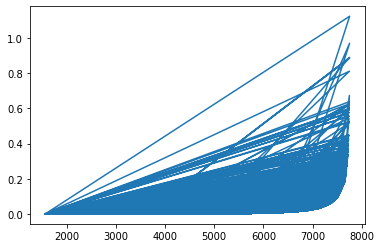

In [ ]:
#YOUR SOLUTION - STRETCH/OPTIONAL
from scipy.stats import rankdata

probabilities = []
for entry in keys:
  term_prob = index.getLexicon()[entry].getFrequency() / index.getCollectionStatistics().getNumberOfTokens()
  probabilities.append(term_prob * 100)

ranks = rankdata(freq)

plt.plot(ranks, probabilities)


Next, Vaswani is a *test collection*, in that it is not just a corpus of documents, but it also has a set of queries (called *topics*), with each query having one or more **known** *relevant* documents (also called *qrels*). We'll hear more about test collections in Lecture 5.

We can easily access the topics and qrels from the dataset. Indeed these are expressed as dataframes as well (we use Pandas's [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) method to show only the first 5 topics):

In [ ]:
vaswani_dataset.get_topics().head(5)

,qid,query
0,1,measurement of dielectric constant of liquids by the use of microwave techniques
1,2,mathematical analysis and design details of waveguide fed microwave radiations
2,3,use of digital computers in the design of band pass filters having given phase and attenuation characteristics
3,4,systems of data coding for information transfer
4,5,use of programs in engineering testing of computers


In [ ]:
vaswani_dataset.get_qrels().head(5)

,qid,docno,label
0,1,1239,1
1,1,1502,1
2,1,4462,1
3,1,4569,1
4,1,5472,1


#### **Task 3**

Using `get_document_direct()` and the qrels, print the contents of the relevant documents for the query with qid "4". NB: qids are strings.

Hint: Try a Pandas apply()?


In [ ]:
#YOUR SOLUTION
qids = vaswani_dataset.get_qrels()
docnos = qids[qids['qid'] == '4']

print("-----Documents with qid 4-----")
print(docnos)
print("-----------------------")

-----Documents with qid 4-----
   qid docno  label
67   4  2042      1
68   4  2180      1
69   4  3595      1
70   4  4057      1
71   4  7985      1
-----------------------


In [ ]:
# doc_direct = docnos.apply(lambda entry : get_document_direct(index, docid = int(entry["docno"])),axis = 1)
# print(doc_direct)
for i in docnos['docno']:
    print("Document", i)
    print(get_document_direct(index, docid = int(i)))
    print('-----------------------')

Document 2042
Docno 2043 (docid 2042)
	system 1
	continu 1
	sens 1
	foil 1
	punch 2
	card 1

-----------------------
Document 2180
Docno 2181 (docid 2180)
	memori 1
	core 1
	nois 1
	current 1
	problem 1
	coincid 1

-----------------------
Document 3595
Docno 3596 (docid 3595)
	digit 1
	comput 1
	electron 1
	count 1
	new 1
	cycl 1
	address 1
	instruct 1

-----------------------
Document 4057
Docno 4058 (docid 4057)
	digit 1
	comput 1
	fast 1
	techniqu 1
	multipl 1
	improv 1
	serial 1

-----------------------
Document 7985
Docno 7986 (docid 7985)
	storag 1
	system 2
	digit 2
	comput 1
	oper 1
	densiti 1
	compon 1
	low 1
	time 1
	form 1
	high 2
	possibl 1
	phosphor 1
	grid 1
	space 1
	perman 1
	decai 1
	arrang 1
	speed 1
	reliabl 1
	advantag 1
	store 2
	commerci 1
	pick 1
	spot 2
	avail 1
	ordin 1
	slide 1
	fly 1

-----------------------


### Weighting Models

So far, we have been using the simple Tf as our ranking function for document retrieval in BatchRetrieve. However, we can use other models such as `"TF_IDF"` by simply changing the `wmodel="Tf"` keyword argument in the constructor of BatchRetrieve.


In [ ]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

tfidf.transform(vaswani_dataset.get_topics().head(1))

,qid,docid,docno,rank,score,query
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids by the use of microwave techniques
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids by the use of microwave techniques
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids by the use of microwave techniques
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids by the use of microwave techniques
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids by the use of microwave techniques
...,...,...,...,...,...,...
995,1,2455,2456,995,2.646072,measurement of dielectric constant of liquids by the use of microwave techniques
996,1,3972,3973,996,2.646072,measurement of dielectric constant of liquids by the use of microwave techniques
997,1,8288,8289,997,2.646072,measurement of dielectric constant of liquids by the use of microwave techniques
998,1,11011,11012,998,2.644992,measurement of dielectric constant of liquids by the use of microwave techniques


You will note that, as expected, the scores of documents ranked by TF_IDF are no longer integers. You can see the exact formula used by Terrier from [the Github repo](https://github.com/terrier-org/terrier-core/blob/5.x/modules/core/src/main/java/org/terrier/matching/models/TF_IDF.java#L79).

Terrier supports many weighting models - the documentation contains [a list of supported models](http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html) - some of which we will discover later in the IR course.


### PyTerrier Transformers

You'll have noted that BatchRetrieve has a `transform()` method that takes as input a dataframe, and returns another dataframe, which is somehow a *transformation* of the earlier dataframe (e.g. a retrieval transformation). In fact, BatchRetrieve is just one of many similar objects in PyTerrier, which we call [transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html) (represented by the TransformerBase class).

Let's give a look at a BatchRetrieve transformer, e.g. the tfidf one:

In [ ]:
#tfidf is a transformer...
print(isinstance(tfidf, pt.transformer.TransformerBase))
#Yes!

# this prints the type hierarchy of the TF_IDF class
tfidf.__class__.__mro__

True


(pyterrier.batchretrieve.BatchRetrieve,
 pyterrier.batchretrieve.BatchRetrieveBase,
 pyterrier.transformer.TransformerBase,
 matchpy.expressions.expressions.Symbol,
 matchpy.expressions.expressions.Atom,
 matchpy.expressions.expressions.Expression,
 object)

One interesting capability of all transformers is that they can be combined using Python operators (this is called operator overloading).

Concretely, imagine that you want to chain transformers together - e.g. rank documents first by Tf then re-ranked the *exact same* documents by BM25. We can do this using the `>>` operator - we call this composition, or "then".

In [ ]:
# this is our first retrieval transformer -
# it transform a queries dataframe to a results dataframe
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf( vaswani_dataset.get_topics().head(1) )

,qid,docid,docno,rank,score,query
0,1,7233,7234,0,9.0,measurement of dielectric constant of liquids by the use of microwave techniques
1,1,3692,3693,1,8.0,measurement of dielectric constant of liquids by the use of microwave techniques
2,1,5501,5502,2,7.0,measurement of dielectric constant of liquids by the use of microwave techniques
3,1,8907,8908,3,7.0,measurement of dielectric constant of liquids by the use of microwave techniques
4,1,6460,6461,4,6.0,measurement of dielectric constant of liquids by the use of microwave techniques
...,...,...,...,...,...,...
995,1,4267,4268,995,1.0,measurement of dielectric constant of liquids by the use of microwave techniques
996,1,532,533,996,1.0,measurement of dielectric constant of liquids by the use of microwave techniques
997,1,4597,4598,997,1.0,measurement of dielectric constant of liquids by the use of microwave techniques
998,1,521,522,998,1.0,measurement of dielectric constant of liquids by the use of microwave techniques


In [ ]:
# now let's define a pipeline 
pipeline = tf >> tfidf
print(isinstance(tfidf, pt.transformer.TransformerBase))

pipeline( vaswani_dataset.get_topics().head(1) )


True


,qid,docid,docno,rank,score,query
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids by the use of microwave techniques
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids by the use of microwave techniques
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids by the use of microwave techniques
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids by the use of microwave techniques
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids by the use of microwave techniques
...,...,...,...,...,...,...
995,1,117,118,995,0.985003,measurement of dielectric constant of liquids by the use of microwave techniques
996,1,4135,4136,996,0.958458,measurement of dielectric constant of liquids by the use of microwave techniques
997,1,1239,1240,997,0.941543,measurement of dielectric constant of liquids by the use of microwave techniques
998,1,4053,4054,998,0.925214,measurement of dielectric constant of liquids by the use of microwave techniques


There are a number of PyTerrier operators - there are more examples in the [PyTerrier documentation on operators](https://pyterrier.readthedocs.io/en/latest/operators.html)

#### **Task 4**

This task aims to improve your understanding of the PyTerrier operators.

**(a)**

Create a ranker that returns the top 10 scored documents based on the following retrieval model:
$$
score(d,Q) = \big( \sum_{t \in Q} w_{TF\_IDF}(t,d) \big)  + 3 * \sum_{t \in Q} tf_{t,d}
$$
In essence, this equation scores documents by linearly combining the scores of two different retrieval models. 

For the correct solution, your pipeline should return no more than 10 documents and document docno `"10703"` should have a score of 10.381090 for query `"chemical"`.

**(b)**

Create a ranker that performs the following:

 - obtains the top 10 highest scoring documents by term frequency (wmodel="Tf")
 - obtains the top 10 highest scoring documents by TF.IDF (wmodel="TF_IDF")
 - reranks only those documents found in BOTH of the previous retrieval settings using BM25.

How many documents are retrieved by this full pipeline for the query "chemical".

If you obtain the correct solution, the document with docno "2558" should have a score of 10.322110 for query "chemical".

Hints:
 - each correct solution needs only a few lines of code if you properly use the PyTerrier operators
 - you should not need to perform any Pandas dataframe operations
 - a Tf BatchRetrieve was already illustrated on the 3-documents index above. You will need an equivalent one on the Vaswani index.

In [ ]:
# YOUR SOLUTION a)
tf = pt.BatchRetrieve(index, wmodel="Tf")
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
pipeline = (tfidf + (3 * tf ))% 10
pipeline.search( 'chemical' )

,qid,docid,docno,score,query,rank
3,1,6278,6279,12.128197,chemical,0
0,1,10702,10703,10.381090,chemical,1
1,1,1055,1056,9.857900,chemical,2
2,1,4885,4886,9.699605,chemical,3
4,1,8765,8766,8.884626,chemical,4
5,1,1139,1140,8.884626,chemical,5
6,1,10138,10139,8.767690,chemical,6
7,1,2519,2520,8.655311,chemical,7
8,1,2557,2558,8.655311,chemical,8
9,1,4686,4687,8.547228,chemical,9


In [ ]:
# YOUR SOLUTION b)



br_tf = pt.BatchRetrieve(index, wmodel="Tf") % 10
print("Top 10 highest scoring documents by term frequency")
print("----------------------------------------")
print(br_tf.search("chemical"))
print("----------------------------------------")

br_tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF") % 10
print("Top 10 highest scoring documents by TFIDF")
print("----------------------------------------")
print(br_tfidf.search("chemical"))
print("----------------------------------------")

bm25 = pt.BatchRetrieve(index, wmodel="BM25")
pipeline = (br_tf & br_tfidf) >> bm25
print("FINAL Pipeline")
print("----------------------------------------")
print(pipeline.search("chemical"))
print("----------------------------------------")

print("Number of documents retrieved by this full pipeline :", len(pipeline.search("chemical")))


Top 10 highest scoring documents by term frequency
----------------------------------------
  qid  docid  docno  rank  score     query
0   1   6278   6279     0    2.0  chemical
1   1  10702  10703     1    1.0  chemical
2   1  10444  10445     2    1.0  chemical
3   1  10138  10139     3    1.0  chemical
4   1   9373   9374     4    1.0  chemical
5   1   8765   8766     5    1.0  chemical
6   1   8415   8416     6    1.0  chemical
7   1   7048   7049     7    1.0  chemical
8   1   2557   2558     8    1.0  chemical
9   1   6128   6129     9    1.0  chemical
----------------------------------------
Top 10 highest scoring documents by TFIDF
----------------------------------------
  qid  docid  docno  rank     score     query
0   1  10702  10703     0  7.381090  chemical
1   1   1055   1056     1  6.857900  chemical
2   1   4885   4886     2  6.699605  chemical
3   1   6278   6279     3  6.128197  chemical
4   1   8765   8766     4  5.884626  chemical
5   1   1139   1140     5  5.884626

### What is Success?

So far, we have been creating search engine models, but we haven't decided if any of them ia actually any good. While we will study *evaluation measures* in Lecture 5, let's just investigate if we are getting a correct ("relevant") document at the first rank.

In [ ]:
qrels = vaswani_dataset.get_qrels()
def get_res_with_labels(ranker, df):
  #get the results for the query or queries
  results = ranker( df )
  # left outer join with the qrels
  with_labels = results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)
  return with_labels

#lets get the Tf results for the first query
get_res_with_labels(tf, vaswani_dataset.get_topics().head(1) )



,qid,docid,docno,rank,score,query,label
0,1,7233,7234,0,9.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
1,1,3692,3693,1,8.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
2,1,5501,5502,2,7.0,measurement of dielectric constant of liquids by the use of microwave techniques,1.0
3,1,8907,8908,3,7.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
4,1,6460,6461,4,6.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
...,...,...,...,...,...,...,...
995,1,4267,4268,995,1.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
996,1,532,533,996,1.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
997,1,4597,4598,997,1.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
998,1,521,522,998,1.0,measurement of dielectric constant of liquids by the use of microwave techniques,0.0


So, we got a relevant document third ranked using Tf. Let's check TF_IDF to see whether it does better:

In [ ]:
#lets get the tfidf results for the first query
get_res_with_labels(tfidf, vaswani_dataset.get_topics().head(1) )

,qid,docid,docno,rank,score,query,label
0,1,8171,8172,0,13.746087,measurement of dielectric constant of liquids by the use of microwave techniques,1.0
1,1,9880,9881,1,12.352666,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
2,1,5501,5502,2,12.178153,measurement of dielectric constant of liquids by the use of microwave techniques,1.0
3,1,1501,1502,3,10.993585,measurement of dielectric constant of liquids by the use of microwave techniques,1.0
4,1,9858,9859,4,10.271452,measurement of dielectric constant of liquids by the use of microwave techniques,1.0
...,...,...,...,...,...,...,...
995,1,2455,2456,995,2.646072,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
996,1,3972,3973,996,2.646072,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
997,1,8288,8289,997,2.646072,measurement of dielectric constant of liquids by the use of microwave techniques,0.0
998,1,11011,11012,998,2.644992,measurement of dielectric constant of liquids by the use of microwave techniques,0.0


Interesting - it got a relevant document at the top rank. Think about what TF_IDF is doing compared to Tf. 

Keeping with the Tf ranking function, let's try to help it perform better by better formulating the query `'measurement of dielectric constant of liquids by the use of microwave techniques'`.

In particular, Terrier can take into account how often a query term occurs in a query. In doing so, documents are actually scored like this:
$$
score(d,Q) = \sum_{t \in Q} tf_{t,q} * tf_{t,d}
$$
where $tf_{t,d}$ is the frequency of the term in *document* and $tf_{t,q}$ is the frequency of the term in the *query*.

However, in our example query ( `'measurement of dielectric constant of liquids by the use of microwave techniques'`) all (non-stopword) query terms have a query term frequency of 1. 

We can try is to give more (or less) weight to some of these query terms, so as to place more or less emphasis on those terms, by appending a number such as `^2` (or `^0.1`) to some words in the query string.

In [ ]:
# here I try to change the emphasis on some words
newQueryDf = pd.DataFrame([
  ["1", "measurement^0.1 of dielectric constant of liquids by "+
    "the use of microwave techniques^2"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf )


,qid,docid,docno,rank,score,query,label
0,1,3692,3693,0,4.00,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
1,1,7233,7234,1,3.60,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
2,1,8907,8908,2,3.20,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
3,1,5501,5502,3,3.05,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,1.0
4,1,8662,8663,4,3.00,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
...,...,...,...,...,...,...,...
995,1,7115,7116,995,0.50,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
996,1,8092,8093,996,0.50,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
997,1,1979,1980,997,0.50,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0
998,1,1991,1992,998,0.50,measurement^0.1 of dielectric constant of liquids by the use of microwave techniques^2,0.0


#### **Task 5**

Spend **up to 5 minutes** trying to reformulate the query by increasing or decreasing the weight of some query terms to get a relevant result at the first rank.

Hint: You might want to inspect some of the relevant (or non-relevant!) documents to see what words they contain. E.g. you might want to look at the contents of docnos 7923 and 3693.

In [ ]:
#YOUR SOLUTION
print(get_document_direct(index, docid=7922))
print(get_document_direct(index, docid=3692))

Docno 7923 (docid 7922)
	calcul 1
	shown 1
	measur 1
	electr 1
	smaller 1
	field 2
	phase 2
	liquid 1
	time 1
	normal 1
	applic 1
	current 1
	experi 1
	new 1
	observ 1
	state 1
	energi 2
	dielectr 4
	influenc 1
	acceler 1
	mass 1
	capacitor 1
	chang 2
	correspond 1
	solid 1
	electro 1
	hundr 1
	heat 1
	phenomenon 1
	dissip 1
	partli 2
	electrod 1
	joul 1
	fusion 2

Docno 3693 (docid 3692)
	electron 5
	deriv 1
	principl 1
	approach 2
	shown 1
	can 1
	theori 1
	develop 1
	part 1
	mai 1
	static 1
	frequenc 1
	group 2
	low 1
	field 1
	depend 1
	case 1
	long 1
	form 1
	rang 1
	high 1
	small 1
	term 1
	constant 4
	quantum 1
	dielectr 4
	first 1
	solid 3
	interact 3
	collect 2
	major 1
	question 1
	isol 1
	larger 1
	minor 1
	plasmon 1
	polariz 1



In [ ]:
newQueryDf_1 = pd.DataFrame([
  ["1", "measurement^2 of dielectric^2 constant of liquids by "+
    "the use of microwave techniques"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf_1 ).head(1)

,qid,docid,docno,rank,score,query,label
0,1,3692,3693,0,6.0,measurement^2 of dielectric^2 constant of liquids by the use of microwave techniques,0.0


In [ ]:
newQueryDf_2 = pd.DataFrame([
  ["1", "measurement of dielectric^3 constant of liquids by "+
    "the use of microwave^2 techniques"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf_2 ).head(1)

,qid,docid,docno,rank,score,query,label
0,1,3692,3693,0,5.333333,measurement of dielectric^3 constant of liquids by the use of microwave^2 techniques,0.0


In [ ]:
newQueryDf_3 = pd.DataFrame([
  ["1", "measurement of dielectric^3 constant^4 of liquids^2 by "+
    "the use of microwave^2 techniques^2"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf_3 ).head(1)

,qid,docid,docno,rank,score,query,label
0,1,3692,3693,0,7.0,measurement of dielectric^3 constant^4 of liquids^2 by the use of microwave^2 techniques^2,0.0


In [ ]:
newQueryDf_4 = pd.DataFrame([
  ["1", "measurement of dielectric^4 constant^4 of liquids by "+
    "the use of microwave techniques^2"]
  ], columns=["qid", "query"])
get_res_with_labels(tf, newQueryDf_4 ).head(1)

,qid,docid,docno,rank,score,query,label
0,1,3692,3693,0,8.0,measurement of dielectric^4 constant^4 of liquids by the use of microwave techniques^2,0.0


**Reflection**: While we could not manually reformulate each user's query, however knowing which words should be important or not can help us understand what a good ranking model should do.

Later in the course, we'll talk about other approaches to (automatically) reformulate queries, such as query expansion, which can help to improve the search engine's effectiveness.


## That's all folks

**Submission Instructions**:
Complete this notebook, and answer the related questions in the [Exercise 1 Quiz Instance on Moodle](https://moodle.gla.ac.uk/mod/quiz/view.php?id=2195723). As part of the Quiz, you will be asked to upload your .ipynb notebook solution and answer a few simple questions (use File... Download .ipynb).

Your responses to the Quiz along with your ipynb notebook solution must be submitted by **Thursday 10th June 2021, 4:30pm**.

Future IR exercises will build upon the learning outcome from this assessed lab. Should you need to reinforce any of the material in this lab, the following parts of the PyTerrier documentation will be useful:
 * [PyTerrier datasets](https://pyterrier.readthedocs.io/en/latest/datasets.html)
 * [Using Terrier for retrieval](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html)
 * [Transformers in PyTerrier](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 * [Transformer Operators](https://pyterrier.readthedocs.io/en/latest/operators.html)